In [ ]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, cm
import os, sys, time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score

import umap

In [2]:
dtype = torch.float
device = torch.device("mps")

transform = transforms.ToTensor()

In [3]:
path = '....'
filename = '...'

In [4]:
def msError(original, prediction):
    error = np.sum((np.array(original) - np.array(prediction))**2, axis = 1) / original.shape[1]
    # print(error)
    return error

In [5]:
def normalize(V):
    V_normalized = (V - V.min(axis=0))/(V.max(axis=0) - V.min(axis=0))
    return V_normalized

In [6]:
def umap_analysis(X_test, model, useGPU, n_neighbors = 5, min_dist = 0.5):

    if useGPU:
        test_X = X_test.to(device)  

    X_embd = model.encoder(test_X)
    X_embd = X_embd.detach().cpu()
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist = min_dist)
    X_values_2D = fit.fit_transform(X_embd)
    
    return X_values_2D

In [7]:
def loadData(filenam, path):
    data = {}
    
    temp_dict = {}
    f = h5py.File(os.path.join(path, filename), "r")
    
    print("Keys: %s" % f.keys())
    
    keys = f.keys()
            
    for i, k in enumerate(keys):
        print(i, type(f[k]))
        if i < 1:
            data[k] = f[k][()]
            print(data[k].shape)
        else:
            data[k] = f[k]
    
    X = data['X']

    return data, X

In [8]:
def extract_cell_families(data):
    cellF = []
    for ct in data['obs']['cell type']['codes'][0:]:
        if ct not in cellF:
            cellF.append(ct)

    cell_types = data['obs']['cell type']['codes'][0:]

    return cellF, cell_types

In [9]:
def shuffle_data(X, cell_types, cellF):

    # shuffling cells
    pc = np.random.permutation(len(cell_types))
    shuffled_cell_types = cell_types[pc]
    
    X = X[pc, :]
    
    
    # shuffling genes
    pg = np.random.permutation(X.shape[1])
    X_shuffled = X[:, pg]
    X = X_shuffled

    catIndex = {}

    for cat in cellF:
        catIndex[cat] = []
        catIndex[cat] = np.where(shuffled_cell_types[0:]==cat)[0]
    
    return X, shuffled_cell_types, catIndex

In [10]:
def splitData(cellF, catIndex, val_split=0.1):

    val_split = 0.1
    
    training_indices = []
    validation_indices = []
    testing_indices = []
    
    sm = 0
    vtsm = 0
    
    for cat in cellF:
        cl = len(catIndex[cat])
        # print(len(catIndex[cat][0:int(cl*(1-2*val_split))]))
        training_indices.extend(catIndex[cat][0:int(cl*(1 - 2*val_split))])
        
        len_tr_indices = len(catIndex[cat][0:int(cl*(1 - 2*val_split))])
        vtsm = cl - len_tr_indices
        # print(cl, len_tr_indices, vtsm)
        
        val_len = int(np.ceil(vtsm / 2))
        
        validation_indices.extend(catIndex[cat][len_tr_indices:len_tr_indices + val_len])
        
        testing_indices.extend(catIndex[cat][len_tr_indices + val_len:])

    training_indices.sort()
    validation_indices.sort()
    testing_indices.sort()

    X_train = X[training_indices, :]
    X_validation = X[validation_indices, :]
    X_test = X[testing_indices, :]

    return training_indices, validation_indices, testing_indices, X_train, X_validation, X_test

In [11]:
data, X = loadData(filename, path)

Keys: <KeysViewHDF5 ['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']>
0 <class 'h5py._hl.dataset.Dataset'>
(1123, 22468)
1 <class 'h5py._hl.group.Group'>
2 <class 'h5py._hl.group.Group'>
3 <class 'h5py._hl.group.Group'>
4 <class 'h5py._hl.group.Group'>
5 <class 'h5py._hl.group.Group'>
6 <class 'h5py._hl.group.Group'>
7 <class 'h5py._hl.group.Group'>
8 <class 'h5py._hl.group.Group'>


In [12]:
signal_size = X.shape[1]
X_scaled = normalize(X)
X = X_scaled
X = torch.from_numpy(X)
output_size = X.shape[1]

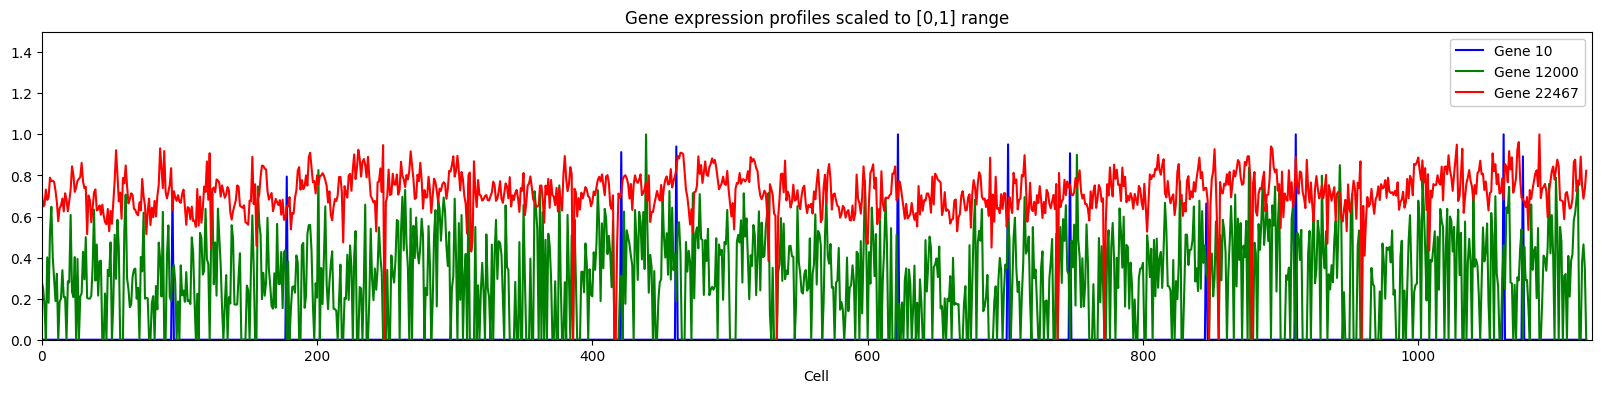

In [13]:
fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(20)

plt.plot(X_scaled[:,10],'b-', label='Gene 10')
plt.plot(X_scaled[:,12000],'g-', label='Gene 12000')
plt.plot(X_scaled[:,22467],'r-', label='Gene 22467')
plt.title('Gene expression profiles scaled to [0,1] range');
ax.legend(loc='upper right', framealpha=1);
plt.xlim([0, 1126])
plt.ylim([0, 1.5])
plt.xlabel('Cell');

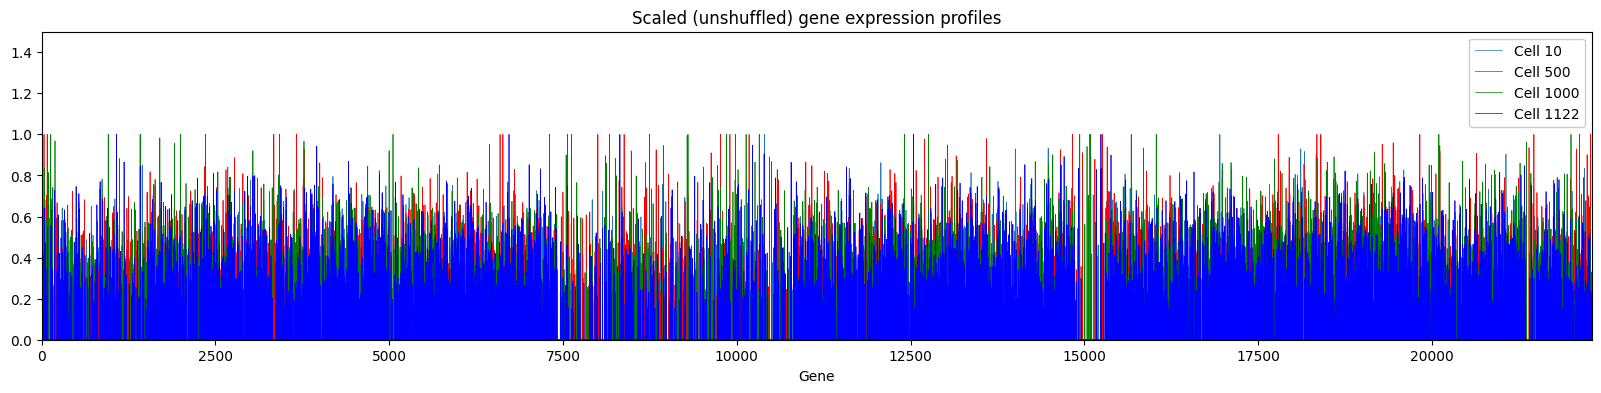

In [14]:
fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(20)

plt.plot(X_scaled[10,:], linewidth=0.5, label='Cell 10')
plt.plot(X_scaled[500,:],'r', linewidth=0.5, label='Cell 500')
plt.plot(X_scaled[1000,:],'g', linewidth=0.5, label='Cell 1000')
plt.plot(X_scaled[1122,:],'b', linewidth=0.5, label='Cell 1122')
plt.title('Scaled (unshuffled) gene expression profiles');
plt.xlabel('Gene')

ax.legend(loc='upper right', framealpha=1);
plt.xlim([0, 22300])
plt.ylim([0, 1.5])
plt.xlabel('Gene');

In [15]:
data['obsm'].keys()

<KeysViewHDF5 ['X_pca', 'X_umap', 'spatial']>

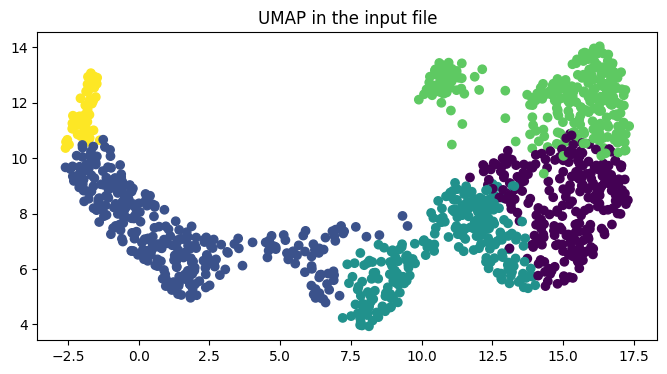

In [16]:
obasm_umap = []

obasm_umap =  data['obsm']['X_umap'][:,:]


fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(8)

plt.scatter(obasm_umap[:, 0], obasm_umap[:, 1], c=data['obs']['cell type']['codes'][:])
plt.title('UMAP in the input file');

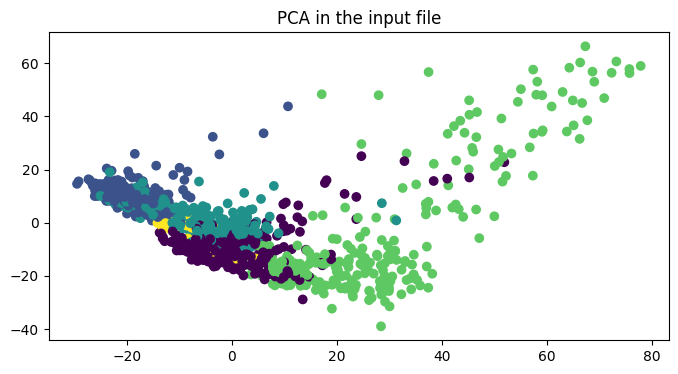

In [17]:
obasm_umap =  data['obsm']['X_pca'][:,:]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

plt.scatter(obasm_umap[:, 0], obasm_umap[:, 1], c=data['obs']['cell type']['codes'][:])
plt.title('PCA in the input file');

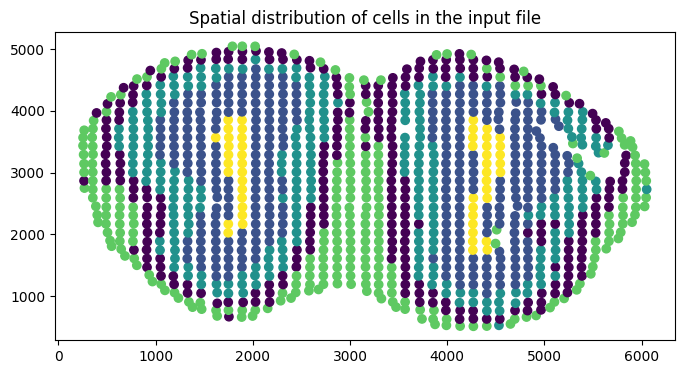

In [18]:
obasm_spatial =  data['obsm']['spatial'][:,:]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

plt.scatter(obasm_spatial[:, 0], obasm_spatial[:, 1], c=data['obs']['cell type']['codes'][:])
plt.title('Spatial distribution of cells in the input file');

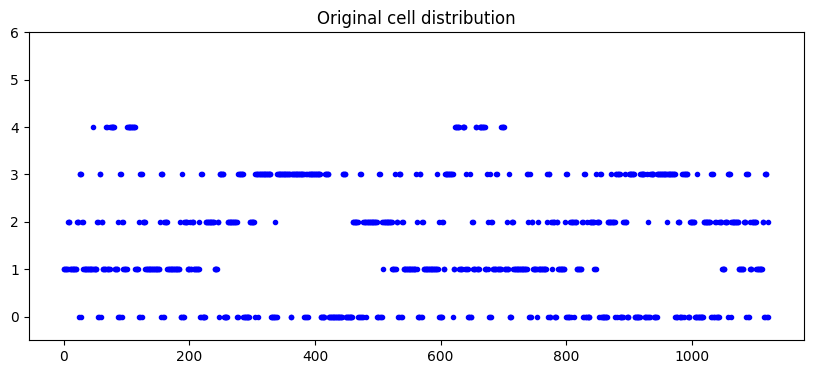

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

cellF, cell_types = extract_cell_families(data)

original_catIndex = {}

for cat in cellF:
    original_catIndex[cat] = []
    original_catIndex[cat] = np.where(cell_types[0:]==cat)[0]


original_training_indices, original_validation_indices, original_testing_indices, \
original_X_train, original_X_validation, original_X_test = splitData(cellF, original_catIndex)

ax.plot(list(range(X.shape[0])), cell_types[:], 'b.')
plt.ylim([-0.5, 6])
plt.title('Original cell distribution');

In [20]:
cellF, cell_types = extract_cell_families(data)
sorted(cellF)

X, shuffled_cell_types, catIndex = shuffle_data(X, cell_types, cellF)


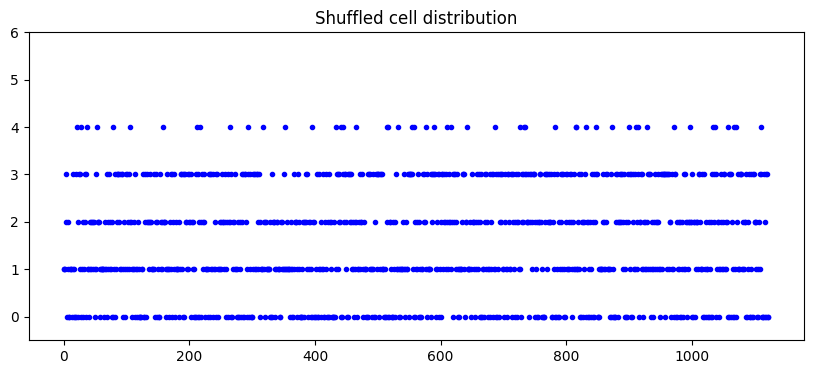

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

ax.plot(list(range(X.shape[0])), shuffled_cell_types[:], 'b.')
plt.ylim([-0.5, 6])

plt.title('Shuffled cell distribution');

In [22]:
train_dataset = TensorDataset(X, X)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=30,
                                              shuffle=True)

In [23]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(signal_size, 2048), # (22468) -> (N, 2048)
            nn.ReLU(),
            nn.Linear(2048, 32),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 2048),
            nn.ReLU(),
            nn.Linear(2048, signal_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [24]:
useGPU = True

# model = Autoencoder()
model = Autoencoder_Linear()
if useGPU:
    model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-5, 
                             weight_decay=1e-5)

In [25]:

silhouette_scores_pca = []
silhouette_scores_umap = []
homogeneity_scores_pca = []
homogeneity_scores_umap = []
last_epoch = 0

In [26]:
class auTrainer(object):
    def __init__(self, data_loader, model, optimizer, criterion, useGPU, device, X):
        self.outputs = []
        self.useGPU = useGPU
        self.data_loader = data_loader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.last_epoch = 0
        self.device = device
        self.reconstruction = None
        self.train_cells = None
        self.cells = None
        
    

    def Train(self, num_epochs, stp=5):
        t0 = time.time()

        for epoch in range(num_epoch):
            
            for train_cells, cells in data_loader:
                if (epoch + 1) % stp == 0:
                    print(".", end="")
                if useGPU:
                    train_cells = train_cells.to(self.device)  
                    cells = cells.to(self.device) 
            
                self.reconstruction = self.model(train_cells)
                loss = self.criterion(self.reconstruction, cells)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
            if (epoch + 1) % stp == 0:
                print("")
                print(f'Run:{epoch + 1 + self.last_epoch}, Loss:{loss.item():.5f}') 
            self.outputs.append((epoch + self.last_epoch, loss))


        self.last_epoch += num_epoch

        self.train_cells = train_cells
        
        t1 = time.time()
        print("\n")
        print("Training completed in {} mins.".format(round((t1 - t0) / 60, 2)))
        print("\n")
        
        

In [27]:
Trainer = auTrainer(data_loader, model, optimizer, criterion, useGPU, device, X)

In [126]:
num_epoch = 100

Trainer.Train(num_epoch, stp=5)


......................................
Run:305, Loss:0.01808
......................................
Run:310, Loss:0.01652
......................................
Run:315, Loss:0.01470
......................................
Run:320, Loss:0.01442
......................................
Run:325, Loss:0.01794
......................................
Run:330, Loss:0.01579
......................................
Run:335, Loss:0.01479
......................................
Run:340, Loss:0.01623
......................................
Run:345, Loss:0.01742
......................................
Run:350, Loss:0.01583
......................................
Run:355, Loss:0.01744
......................................
Run:360, Loss:0.01801
......................................
Run:365, Loss:0.01786
......................................
Run:370, Loss:0.01768
......................................
Run:375, Loss:0.01491
......................................
Run:380, Loss:0.01381
........................

In [127]:
eps = [o[0] for o in Trainer.outputs]

losses = [t[1].item() for t in Trainer.outputs]

print(len(Trainer.outputs))

400


(0.01, 0.05)

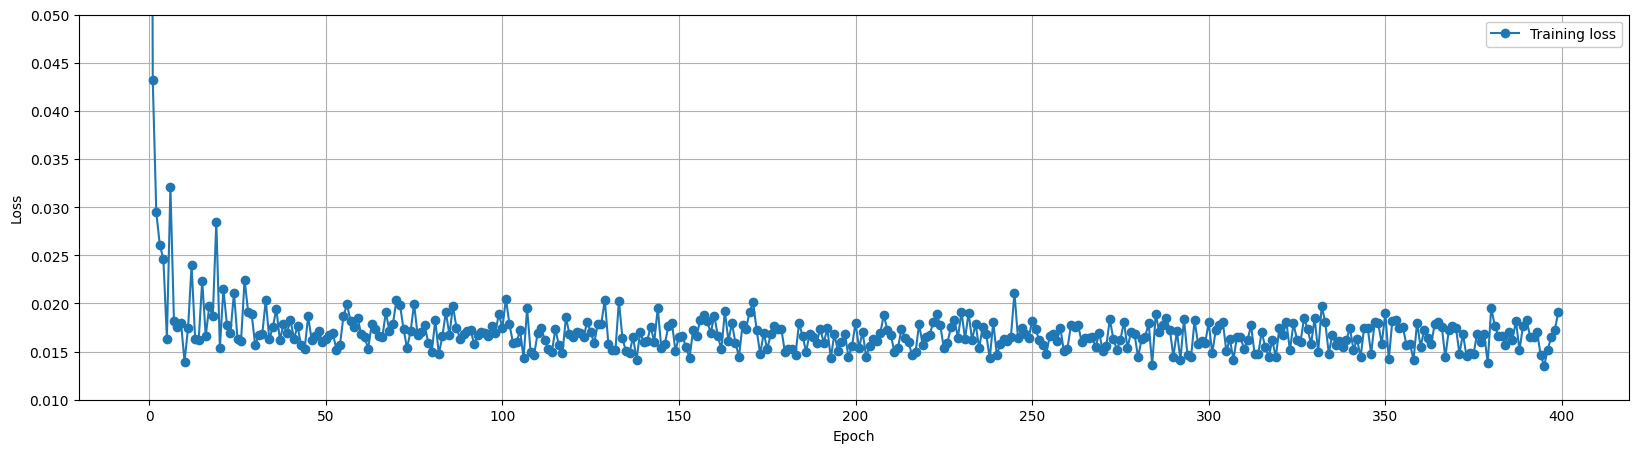

In [128]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(eps, losses, 'o-', label='Training loss')
# plt.plot(eps, val_losses, 'o-', label='Validation loss')
ax.legend(loc='upper right', framealpha=1);
plt.grid()
plt.ylim([0.010, 0.05])

In [111]:
which_cell = 10

nrec = [r.item() for r in Trainer.reconstruction[which_cell]]
ncell = [c.item() for c in Trainer.train_cells[which_cell]]

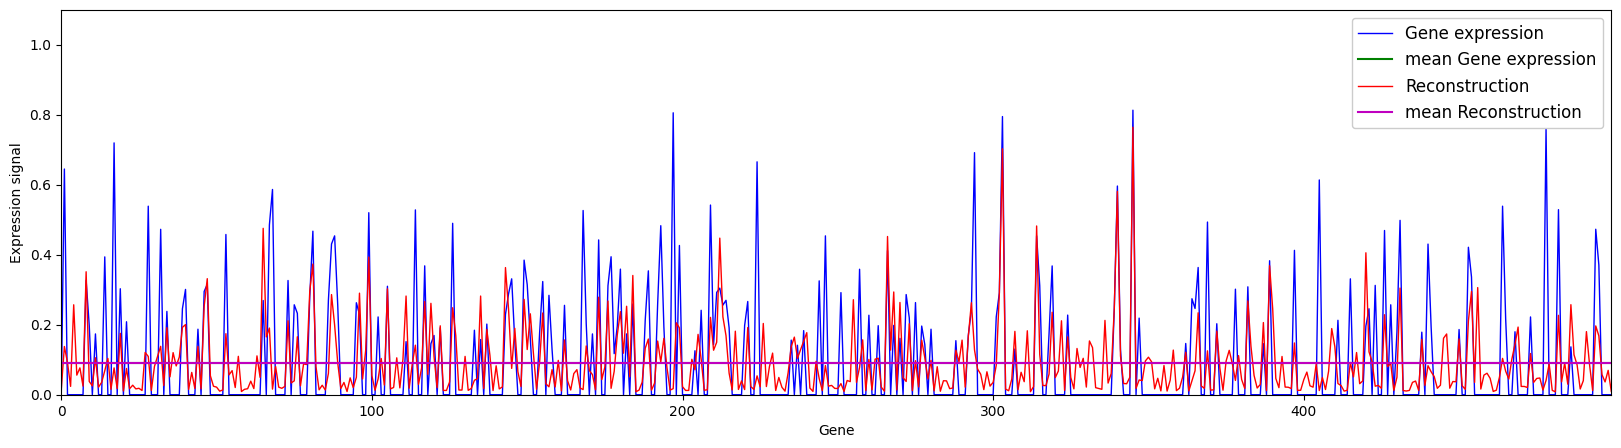

In [112]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)


start = 0
ln = 500


genes = [i for i in range(start, start+ln)]

mean_prediction = np.full(len(nrec), np.mean(nrec))

mean_test = np.full(len(ncell), np.mean(ncell))


ax.plot(genes, ncell[start:start + ln], 'b-', label='Gene expression', linewidth=1)
ax.plot(genes, mean_test[start:start + ln],    'g-', label='mean Gene expression')
ax.plot(genes, nrec[start:start + ln], 'r-', label='Reconstruction', linewidth=1)
ax.plot(genes, mean_prediction[start:start + ln],   'm-', label='mean Reconstruction')
plt.xlabel('Gene')
plt.ylabel('Expression signal')

plt.ylim([0.0, 1.1])
plt.xlim([min(genes), max(genes)])

ax.legend(loc='upper right', framealpha=1, fontsize=12);

In [129]:
mean_prediction[0] - mean_test[0]

-0.0005354650024174956

In [130]:
n_neighbors = 7
min_dist = 1

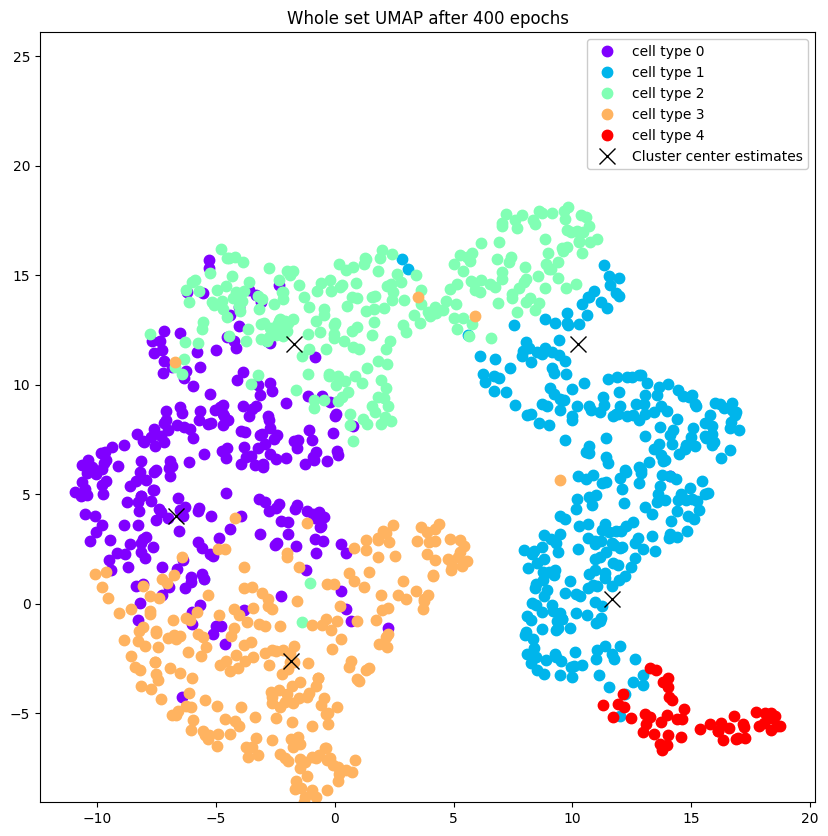

In [138]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)


X_whole_2D_umap = umap_analysis(X, model, useGPU, n_neighbors, min_dist = min_dist)
umap_silhouette_score = silhouette_score(X_whole_2D_umap, shuffled_cell_types)

kmeans_umap =  KMeans(n_clusters=5, random_state = 42)
kmeans_umap.fit(X_whole_2D_umap)
homogeneity_umap_score = homogeneity_score(shuffled_cell_types, kmeans_umap.labels_)


silhouette_scores_umap.append((Trainer.last_epoch, umap_silhouette_score))
homogeneity_scores_umap.append((Trainer.last_epoch, homogeneity_umap_score)) 

clusterCenters_umap = kmeans_umap.cluster_centers_



colorIndex = []
for i in cellF:
    colorIndex.append(np.where(shuffled_cell_types == i)[0][0])

colors = plt.cm.rainbow(np.linspace(0,1,5))

for i, v in enumerate(cellF):
     plt.plot(X_whole_2D_umap[colorIndex[i],0], X_whole_2D_umap[colorIndex[i],1], '.', markersize=15, label = 'cell type {}'.format(i), color=colors[i])

for i, v in enumerate(cellF):
    for j in np.where(shuffled_cell_types == i)[0]:
        plt.plot(X_whole_2D_umap[j,0], X_whole_2D_umap[j,1], '.', markersize=15, color=colors[i])

plt.plot(clusterCenters_umap[:,0], clusterCenters_umap[:,1], 'kx', markersize=12 , linewidth=3, label='Cluster center estimates')



ax.legend(loc='upper right', framealpha=1);
plt.ylim([min(X_whole_2D_umap[:,1]), max(X_whole_2D_umap[:,1]) + 8])
plt.title('Whole set UMAP after {} epochs'.format(Trainer.last_epoch));

In [139]:
process_X = X.to(device)  
X_embd = model.encoder(process_X)
X_embd = X_embd.detach().cpu()

pca = PCA(n_components=10)

pca.fit(X_embd)

pca_X = pca.transform(X_embd)

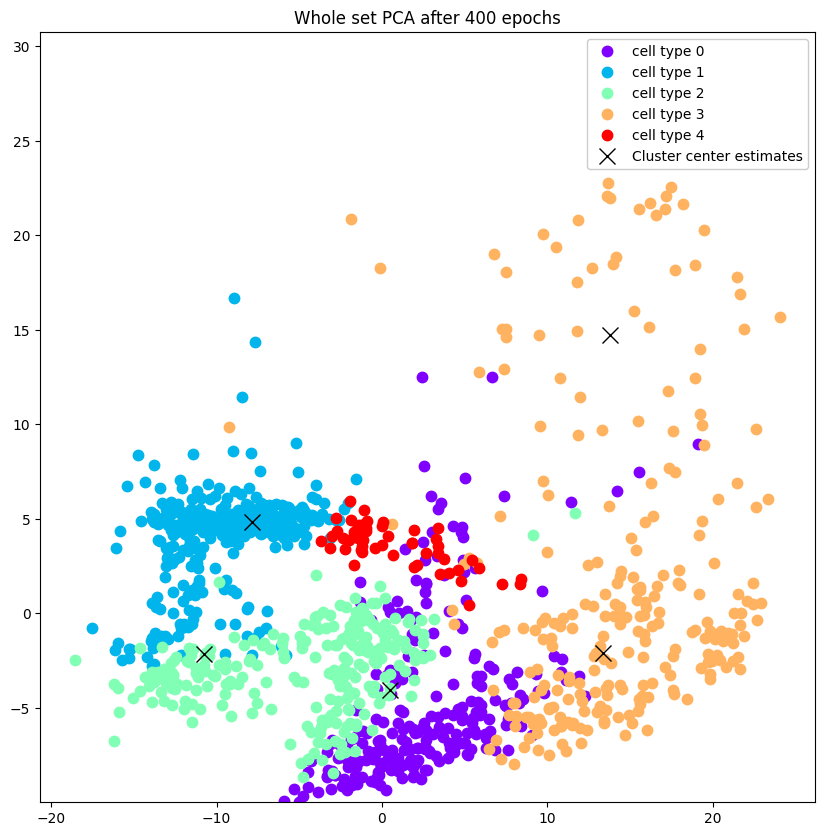

In [141]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)


pca_silhouette_score = silhouette_score(pca_X, shuffled_cell_types)

kmeans_pca =  KMeans(n_clusters=5, random_state = 42)
kmeans_pca.fit(pca_X)
homogeneity_pca_score = homogeneity_score(shuffled_cell_types, kmeans_pca.labels_)

silhouette_scores_pca.append((Trainer.last_epoch, pca_silhouette_score))
homogeneity_scores_pca.append((Trainer.last_epoch, homogeneity_pca_score)) 

clusterCenters_pca = kmeans_pca.cluster_centers_

colorIndex = []
for i in cellF:
    colorIndex.append(np.where(shuffled_cell_types == i)[0][0])

colors = plt.cm.rainbow(np.linspace(0,1,5))

for i, v in enumerate(cellF):
     plt.plot(pca_X[colorIndex[i],0], pca_X[colorIndex[i],1], '.', markersize=15, label = 'cell type {}'.format(i), color=colors[i])

for i, v in enumerate(cellF):
    for j in np.where(shuffled_cell_types == i)[0]:
        plt.plot(pca_X[j,0], pca_X[j,1], '.', markersize=15, color=colors[i])

plt.plot(clusterCenters_pca[:,0], clusterCenters_pca[:,1], 'kx', markersize=12 , linewidth=3, label='Cluster center estimates')

ax.legend(loc='upper right', framealpha=1);
plt.ylim([min(pca_X[:,1]), max(pca_X[:,1]) + 8])
plt.title('Whole set PCA after {} epochs'.format(Trainer.last_epoch));

In [142]:
silhouette_scores_pca

[(10, -0.22255307561905407),
 (100, 0.2465104746983877),
 (200, 0.25846808169483854),
 (300, 0.2625741684774796),
 (400, 0.2616427068610158)]

In [143]:
homogeneity_scores_pca

[(10, 0.12348627485103109),
 (100, 0.5980517068110481),
 (200, 0.6046201221316371),
 (300, 0.6058088454080808),
 (400, 0.6030448596945404)]

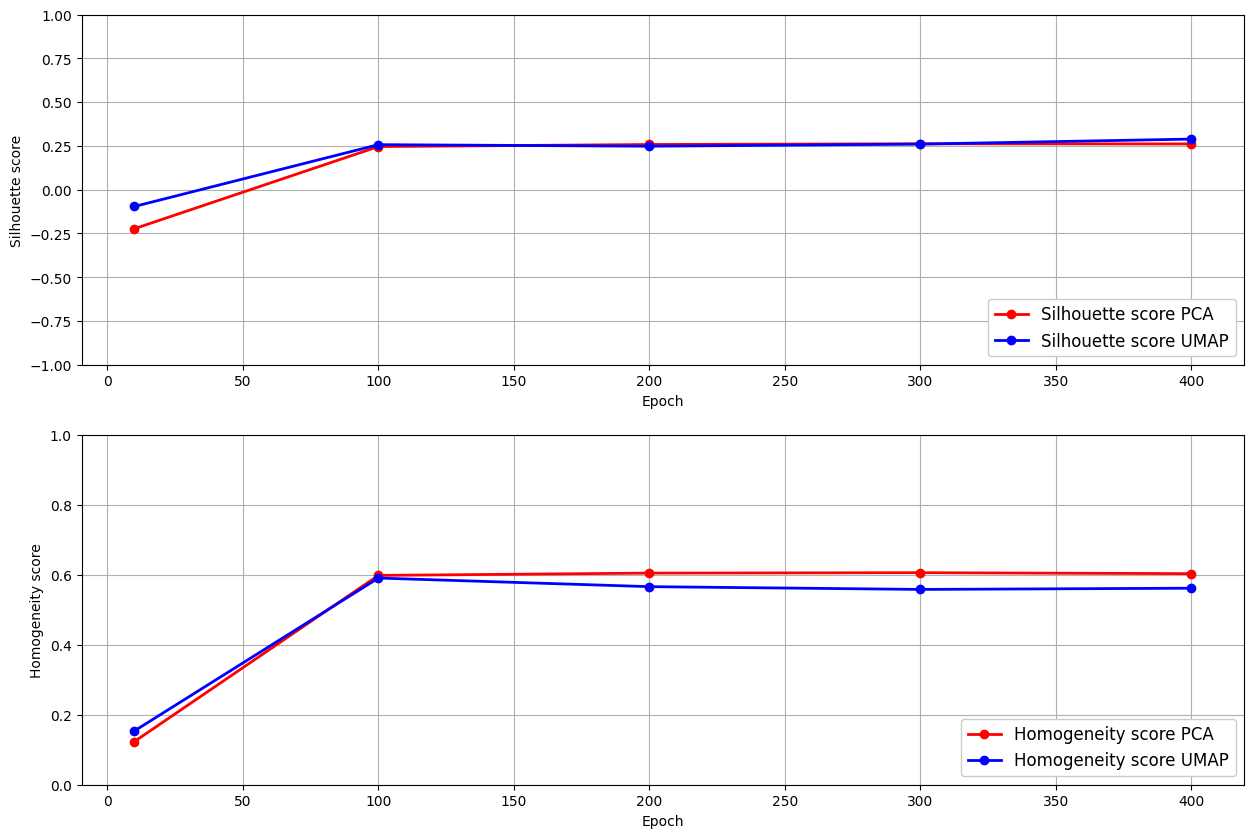

In [145]:
fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(15)



ax[0].plot([s[0] for s in silhouette_scores_pca], [s[1] for s in silhouette_scores_pca], 'ro-', label='Silhouette score PCA', linewidth=2)
ax[1].plot([s[0] for s in homogeneity_scores_pca], [s[1] for s in homogeneity_scores_pca], 'ro-', label='Homogeneity score PCA', linewidth=2)

ax[0].plot([s[0] for s in silhouette_scores_umap], [s[1] for s in silhouette_scores_umap], 'bo-', label='Silhouette score UMAP', linewidth=2)
ax[1].plot([s[0] for s in homogeneity_scores_umap], [s[1] for s in homogeneity_scores_umap], 'bo-', label='Homogeneity score UMAP', linewidth=2)


ax[0].legend(loc='lower right', framealpha=1, fontsize=12);
ax[1].legend(loc='lower right', framealpha=1, fontsize=12);

ax[0].grid()
ax[1].grid()

ax[0].set_ylim(-1,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Silhouette score')
ax[1].set_ylabel('Homogeneity score');
